In [2]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/'
source = source_dir+'aqua_2m/'
            
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/")
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/")

fig_dest="/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/"

a=6371.0e3
R=a

In [3]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

NC=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM_compiled/*.nc'))

In [4]:
NC

['/project2/tas1/pragallva/Tiffany_ECHAM_compiled/BOT_rp000058_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM_compiled/BOT_rp000046_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM_compiled/BOT_rp000086_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM_compiled/BOT_rp000034_0010_39.nc']

In [5]:
m5_nc=nc.Dataset(NC[2],'r'); 
m10_nc=nc.Dataset(NC[3],'r'); 
m50_nc=nc.Dataset(NC[1],'r'); 
m100_nc=nc.Dataset(NC[0],'r');
keys=m5_nc.variables.keys()
# print keys

In [6]:
longname=[0,0,0]

for i in range(0,len(keys)):
    if ( (i!=2) and (i!=15) and (i!=14) and (i!=16) ) :
#         longname=np.append(longname, m5_nc.variables[keys[i]].long_name)
        print i,'. ',keys[i], '--' ,m5_nc.variables[keys[i]].long_name

0 .  lon -- longitude
1 .  lat -- latitude
3 .  tradl -- thermal radiation 200mb
4 .  sradl -- solar radiation 200mb
5 .  trafl -- thermal radiation 200mb (clear sky)
6 .  srafl -- solar radiation 200mb (clear sky)
7 .  trfliac -- LW flux over ice
8 .  trflwac -- LW flux over water
9 .  trfllac -- LW flux over land
10 .  sofliac -- SW flux over ice
11 .  soflwac -- SW flux over water
12 .  sofllac -- SW flux over land
13 .  friac -- ice cover (fraction of grid box)
17 .  tsw -- surface temperature of water
18 .  ustri -- zonal      wind stress over ice
19 .  vstri -- meridional wind stress over ice
20 .  ustrw -- zonal      wind stress over water
21 .  vstrw -- meridional wind stress over water
22 .  ustrl -- zonal      wind stress over land
23 .  vstrl -- meridional wind stress over land
24 .  ahfliac -- latent heat flux over ice
25 .  ahflwac -- latent heat flux over water
26 .  ahfllac -- latent heat flux over land
27 .  evapiac -- evaporation over ice
28 .  evapwac -- evaporation o

In [8]:
m5_nc.variables['evap'][:].shape

(1, 12, 96, 192)

In [9]:
def RAD(X):
    def R(y):
        return y.mean(axis=-1).mean(axis=0).transpose()
    SW_sfc= R(X['srads'][...]) # net surface solar radiation
    SW_toa= R(X['srad0'][...]) # net top solar radiation
    olr   = R(X['trad0'][...])    # top thermal radiation (OLR)
    LW_sfc= R(X['trads'][...]) # net surface thermal radiation
    shflx =R(X['ahfs'][...])    # ahfs -- sensible heat flux
    lhflx =R(X['ahfl'][...])    # ahfl -- latent heat flux
          
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx    

In [10]:
SW_sfc=np.zeros((4,96,12)); SW_toa=np.copy(SW_sfc); 
LW_sfc=np.copy(SW_sfc); shflx=np.copy(SW_sfc); 
lhflx=np.copy(SW_sfc); olr=np.copy(SW_sfc);

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc[i,...], SW_toa[i,...], olr[i,...], LW_sfc[i,...], shflx[i,...], lhflx[i,...] = RAD(X[i])

lat=m5_nc['lat'][:]

In [13]:
TOA= +SW_toa + olr                   ## downwards
SFC= shflx + lhflx + LW_sfc + SW_sfc   ## upwards
Net_rad=SFC+TOA

SWABS= +SW_toa + SW_sfc
SHF  = shflx + lhflx + LW_sfc
Net_rad2= SWABS + SHF + olr

In [11]:
def zon_int(x):
    y=x#*2*np.pi*np.cos(np.deg2rad(lat[:,None]))*a
    return y/10**15

import scipy.integrate as integrate
def integrated(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    #int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1,:]) #int_x[::-1,:][1:,:]+
    return avg_int_r/10**15

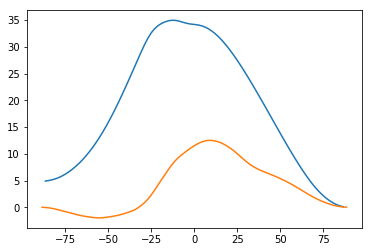

In [38]:
m=0
k=integrated(Net_rad[0,...])
py.plot(lat[1:-1],k[:,m] )
py.plot(lat,(TE+SE+MM)[0,:,m])
py.show()

In [19]:
MAT=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.mat'))

In [20]:
m5=sio.loadmat(MAT[0]); 
m10=sio.loadmat(MAT[2]); 
m50=sio.loadmat(MAT[1]); 
m100=sio.loadmat(MAT[3]);

In [21]:
def MSE(X):
    MM= (X['mean_cpt_monthly']+X['mean_gz_monthly']+X['mean_Lq_monthly']).mean(axis=1)
    SE= (X['seddy_cpt_monthly']+X['seddy_gz_monthly']+X['seddy_Lq_monthly']).mean(axis=1)
    TE= (X['teddy_cpt_monthly']+X['teddy_gz_monthly']+X['teddy_Lq_monthly']).mean(axis=1)
    return zon_int(MM), zon_int(SE),  zon_int(TE)    ## Actually it is already 

In [22]:
MM=np.zeros((4,96,12)); SE=np.copy(MM); TE=np.copy(MM)

In [23]:
X=[m5, m10, m50, m100]
for i in range(4) :
    MM[i,...], SE[i,...], TE[i,...] = MSE(X[i])

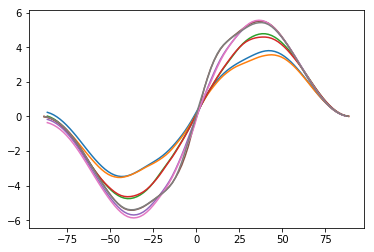

In [24]:
for m in range(0,4):
    py.plot(lat[1:-1], integrated(Net_rad[m,...]).mean(axis=-1))
    py.plot(lat[:], (TE+SE+MM)[m,...].mean(axis=-1))
py.show()